In [1]:
from transform import *
from data import *
from model import *
from tools import *
import torch.optim as optim
from tensorboardX import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

In [2]:
root1 = '/home/whale/dataset/Landmark/300W'
root2 = '/home/whale/dataset/Landmark/300W_LP'

train1 = os.path.join(root1, "train.xml")
test1 = os.path.join(root1, "test.xml")
train2 = os.path.join(root2, "train.txt")
test2 = os.path.join(root2, "test.txt")

composed = transforms.Compose([CropByLDK(1.4), Flip(), RandomCrop(0.7), Rescale((64,64)), ToTensor(), Normalize()])

epoch:0 iteration:499 loss:0.0193534846101
epoch:0 iteration:999 loss:0.00821817355324


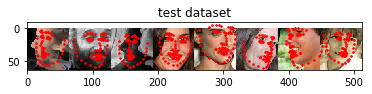

epoch:1 iteration:499 loss:0.00548490091832
epoch:1 iteration:999 loss:0.00455912109092


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir='logs')


trainset = Dataset_combined([Ldk_300W_LP_Dataset(train2, root2, composed)
                            , Ldk_300W_Dataset(train1, root1, composed)])

testset = Dataset_combined([Ldk_300W_LP_Dataset(test2, root2, composed)
                            , Ldk_300W_Dataset(test1, root1, composed)])
trainset[0]
net= MobileNetV2() 
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
save_path = '/home/whale/workspace/torch/mobile-landmark/landmark.pth'

epoch, batch_size = 30, 32

train(device, net, criterion, optimizer, trainset, testset, epoch, batch_size, save_path, writer)